<a href="https://colab.research.google.com/github/intellitrend-global/google_hackathon_bq_ai/blob/main/process_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 ESG & 💲Financial Intelligence Platform
## AI-Powered Analysis of Corporate Reports (ESG And Annual)

**🎯 What this does:**
- Automatically processes PDF reports from Google Cloud Storage
- Uses Gemini 2.5 Pro to extract financial & ESG metrics
- Generates forecasts using Google's TimesFM 2.0 model
- Analyzes companies: Amgen, Novartis, Target

**📊 Features:**
- ✅ Automated PDF processing from Cloud Storage
- ✅ AI-powered data extraction (Financial + ESG metrics)
- ✅ Revenue forecasting with TimesFM 2.0
- ✅ Multi-company comparative analysis



# 🔑Setup & Authentication

In [35]:

print("🌟 Welcome to the ESG & Financial Intelligence Platform!")
print("🔧 Setting up environment...")

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install required packages
!pip install -q bigframes google-cloud-bigquery plotly seaborn

# Import libraries
import bigframes.pandas as bpd
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


print("✅ Authentication complete!")
print("✅ Libraries installed!")

🌟 Welcome to the ESG & Financial Intelligence Platform!
🔧 Setting up environment...
✅ Authentication complete!
✅ Libraries installed!


# 🚀 Intializing Parameters

In [44]:
# Replace the below with other company names from this list:
# novartis, amgen, target, bankofmontreal, lloyd, wellsfargo
# we can use an array / list if we need to process more than one company

company1 = "novartis"
company2 ="unitedhealth"
company3 = "amgen"

DATA_FILES_PATH="gs://report_insights"

PROJECT_ID = "intellitrend-project-dev"   # update if needed
PROJECT_LOCATION="US" # Others are EU, ASIA
CLOUD_RES_CONN = "ghack_conn" #must be all small case


DATASET_ID = "db_reports_insights_annual_esg" #Name of dataset to be created in BQ

OBJ_TABLE_ID = "all_reports_obj_table_metadata" #Objec table name. That holds the metadata of the source files in GCS
RAW_TABLE_ID="all_reports_ai_text_raw"   # the output text that gets extracted based on prmpt - using ML.GENERATE_TEXT

CURATED_TABLE_ID="all_reports_ai_text_curated" # response_text extracted from JSON output
CURATED2_TABLE_ID="all_reports_ai_text_curated2" # the output text that gets extracted based on prmpt - using AI.GENERATE (An alternate way - for comparison)

FINAL_TABLE_ID="all_reports_ai_text_final" # output metrics info from the curated table - using AI.GENERATE_TABLE

METRICS_TABLE_ID = "all_reports_metrics"  # format the output final table
FORECAST_TABLE_ID="all_reports_forecast" # forecast table from the formatted-output

QUALIFIED_CLOUD_RES_CONN = f"{PROJECT_ID}.{PROJECT_LOCATION}.{CLOUD_RES_CONN}"

QUALIFIED_OBJ_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{OBJ_TABLE_ID}"
QUALIFIED_RAW_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{RAW_TABLE_ID}"

QUALIFIED_CURATED_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED_TABLE_ID}"
QUALIFIED_CURATED2_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED2_TABLE_ID}"

QUALIFIED_METRICS_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{METRICS_TABLE_ID}"

QUALIFIED_FINAL_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FINAL_TABLE_ID}"
QUALIFIED_FORECAST_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FORECAST_TABLE_ID}"

MODEL_ENDPOINT="gemini-2.5-pro" # or any other gemini model
MODEL_NAME="gemini_model_25pro"
QUALIFIED_MODEL_ID=f"{PROJECT_ID}.{DATASET_ID}.{MODEL_NAME}"




# --- Bigframes setup ---
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# 🏗️ Project Configuration

In [37]:

from google.colab import userdata

# Configure BigFrames
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

print(f"✅ Project configured: {PROJECT_ID}")
print("✅ BigFrames ready for action!")

✅ Project configured: intellitrend-project-dev
✅ BigFrames ready for action!


# 🔗Create Cloud Resource Connection

In [38]:
!bq mk \
  --connection \
  --project_id={PROJECT_ID} \
  --connection_type=CLOUD_RESOURCE \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN}

BigQuery error in mk operation: Already Exists: Connection
projects/573553606303/locations/us/connections/ghack_conn


# 🆔Fetch Service Account associated with the Cloud Res Connection

In [39]:
SERVICE_ACCT = !bq show --format=prettyjson \
  --connection \
  --project_id={PROJECT_ID} \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN} | grep "serviceAccountId" | cut -d '"' -f 4

SERVICE_ACCT_EMAIL = SERVICE_ACCT[0]  # first (and only) line
print(SERVICE_ACCT_EMAIL)

bqcx-573553606303-2s0n@gcp-sa-bigquery-condel.iam.gserviceaccount.com


# 👥Give the below roles to the Conn Service Account:
  * objectViewer and  
  * aiplatformUser



In [40]:
import time

# Use $SERVICE_ACCT_EMAIL so the Python variable expands in the shell
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/storage.objectViewer" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/aiplatform.user" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/bigquery.connectionUser" \
    --format=none


!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/run.invoker" \
    --format=none


# Wait ~60 seconds for IAM updates to propagate
# time.sleep(60)

Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].


#✦ Create the Gemini Model

In [41]:
# 🤖 Step 0a: Create Gemini 2.5 Pro Model
print("🤖 Creating Gemini 2.5 Pro model...")

create_model_sql = f"""
CREATE OR REPLACE MODEL `{QUALIFIED_MODEL_ID}`
REMOTE WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (ENDPOINT = '{MODEL_ENDPOINT}');
"""

try:
    job = client.query(create_model_sql)
    job.result()
    print("🎉 Gemini 2.5 Pro model created successfully!")
except Exception as e:
    print(f"⚠️  Model creation issue: {e}")

🤖 Creating Gemini 2.5 Pro model...
🎉 Gemini 2.5 Pro model created successfully!


# 𝄜 Create **Object Table** for PDF Reports

In [45]:
print(f"📁 Creating external table(Object Table): '{OBJ_TABLE_ID}' for PDF reports...")

create_external_table_sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['{DATA_FILES_PATH}/{company1}/*', '{DATA_FILES_PATH}/{company2}/*', '{DATA_FILES_PATH}/{company3}/*']
);
"""

# Uncomment to process a single file for testing

# create_external_table_sql = f"""
# CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
# WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
# OPTIONS (
#   object_metadata = 'SIMPLE',
#   uris = ['{DATA_FILES_PATH}/{company1}/{company1}_annualreport_2020.pdf']
# );
# """

try:
    job = client.query(create_external_table_sql)
    job.result()
    print("✅ External table created successfully!")

    # Check what files we have
    check_files_sql = f"SELECT uri, size FROM `{QUALIFIED_OBJ_TABLE_ID}`  "
    files_df = bpd.read_gbq(check_files_sql)
    print(f"📄 Found {len(files_df)} files in storage")
    print("Sample files:")
    print(files_df.head())


except Exception as e:
    print(f"⚠️  Note: {e}")
    print("   Make sure your GCS bucket and connection are set up correctly")



📁 Creating external table(Object Table): 'all_reports_obj_table_metadata' for PDF reports...
✅ External table created successfully!
📄 Found 33 files in storage
Sample files:


                                                 uri     size
0  gs://report_insights/novartis/novartis_annualr...  4228147
1  gs://report_insights/novartis/novartis_annualr...  3767323
2  gs://report_insights/novartis/novartis_annualr...  3598595
3  gs://report_insights/novartis/novartis_annualr...  3990455
4  gs://report_insights/novartis/novartis_annualr...  3861068

[5 rows x 2 columns]


#  ֎ Extract Financial & ESG Data - **Using ML.GENERATE_TEXT**

In [46]:

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
    STRUCT(
      '''
        You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability details and metrics from text, tabular and image data for each PDF.

      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  )
WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%'
);
"""
#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... ")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes novartis, unitedhealth, and amgen reports...
⏳ Processing... 
✅ Successfully processed 33 files!


# 🧹 Extract **Clean** Text Response

In [47]:
print("🧹 Cleaning and extracting response text...")

curate_results_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED_TABLE_ID}` AS
SELECT *,
  ARRAY_TO_STRING(
    ARRAY(
      SELECT JSON_VALUE(part, '$.text')
      FROM UNNEST(JSON_QUERY_ARRAY(
        JSON_QUERY(ml_generate_text_result, '$.candidates[0].content.parts')
      )) AS part
    ),
    ''
  ) AS response_text
FROM
  `{QUALIFIED_RAW_TABLE_ID}`;
"""

try:
    job = client.query(curate_results_sql)
    job.result()
    print("✅ Response text extracted and cleaned!")

    # Show sample of extracted text
    sample_sql = f"""
    SELECT uri, LEFT(response_text, 200) as sample_text
    FROM `{QUALIFIED_CURATED_TABLE_ID}`
    LIMIT 3
    """
    sample_df = bpd.read_gbq(sample_sql)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df.iterrows():
        print(f"File: {row['uri']}")
        print(f"Text: {row['sample_text']}...\n")

except Exception as e:
    print(f"⚠️  Text extraction issue: {e}")

🧹 Cleaning and extracting response text...
✅ Response text extracted and cleaned!

📝 Sample extracted text:
File: gs://report_insights/amgen/amgen_sustainabilityreport_2024.pdf
Text: Here are the financial and sustainability details from the Amgen 2024 Sustainability Highlights Report.

### Financial Details

| Metric | 2024 | 2023 | Source |
| --- | --- | --- | --- |
| **Total Re...

File: gs://report_insights/amgen/amgen_sustainabilityreport_2023.pdf
Text: ```json
{"company_name": "Amgen", "year": 2023, "url": "https://www.amgen.com/sustainability/2023-esg-report", "source_file": "Amgen 2023 ESG Report", "financial_and_sustainability_details": {"General...

File: gs://report_insights/novartis/novartis_sustainability_2021.pdf
Text: Based on the "Novartis in Society Integrated Report 2021," here is a summary of the key financial and sustainability details.

### Sustainability and ESG

#### **Overall ESG Strategy & Performance**
-...



In [50]:
from IPython.display import display, Markdown

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

user_question="'What is the total revenue this year?'"
user_question=""
selected_company = "unitedhealth"
selected_year = "2024"
selected_report_type="annual"

if selected_report_type=="annual":
  default_questions="""
CONCAT('Answer all the below questions:',
'Read the data and fetch the below details:',
'Financial Performance',
'What is the total revenue this year?',
'How has revenue changed compared to last year?',
'What is the net profit or loss?',
'How have the earnings per share (EPS) changed?',
'Are gross margins improving or declining?',
'Are operating margins stable or volatile?',
'How has net margin shifted year over year?',
'Is cash flow from operations positive and consistent?',
'How much free cash flow is available?',
'How are working capital levels trending?',

'Balance Sheet & Liquidity',
'What is the total debt level?',
'Is the debt-to-equity ratio rising or falling?',
'Does the company have enough liquidity to cover short-term liabilities?',
'What is the current ratio and quick ratio?',
'How much cash and equivalents are available?',
'Are interest expenses sustainable?',
'How sensitive is the company to interest rate changes?',
'What is the level of contingent liabilities?',

'Business Strategy',
'What are the company’s core growth initiatives?',
'Is management investing in new markets or products?',
'How much is spent on research and development (R&D)?',
'Are acquisitions or divestitures planned?',
'Is the company expanding geographically?',
'What is the company competitive advantage?',
'Is the advantage sustainable against competitors?',
'Is digital transformation a core part of the strategy?',

'Risk Factors',
'What macroeconomic risks affect the business?',
'What industry-specific risks are highlighted?',
'What operational risks are disclosed?',
'Are supply chain risks material?',
'Are legal or regulatory risks mentioned?',
'How is foreign exchange risk managed?',
'How dependent is revenue on a few customers?',
'Are raw material price risks significant?',

'Governance & Leadership',
'Is the board majority independent?',
'How many women or minorities are on the board?',
'Is executive compensation performance-linked?',
'Does management own significant equity?',
'Are shareholder rights well protected?',
'Is succession planning disclosed?',
'Has management delivered on past promises?',
'Is the auditor independent and credible?',

'Shareholder Value',
'Is the company paying dividends?',
'Is the dividend payout sustainable?',
'Is the dividend policy clear?',
'Are share buybacks taking place?',
'Is return on equity (ROE) improving?',
'Is return on assets (ROA) stable?',
'Has shareholder equity grown consistently?',
'What is the earnings guidance for next year?'
)
"""
else:
  default_questions="""
CONCAT('Answer all the below questions:',
'Read the data and fetch the below details:',
'Investor Questions – Sustainability Reports',

'Environmental',
'What is the total Scope 1 emissions?',
'What is the total Scope 2 emissions?',
'What is the total Scope 3 emissions?',
'Are science-based targets disclosed?',
'Has the company committed to net-zero?',
'What percentage of energy is renewable?',
'Is energy efficiency improving year over year?',
'What is the total water withdrawal?',
'What is water recycled or reused?',
'Is the company exposed to water stress?',
'How much total waste is generated?',
'How much waste is recycled or diverted from landfill?',
'Are hazardous waste levels disclosed?',
'How sustainable are raw material sourcing practices?',
'Are biodiversity risks addressed?',

'Social',
'What is the total workforce size?',
'What percentage of employees are women?',
'What percentage of leadership roles are held by women?',
'What is minority representation in the workforce?',
'What is the employee turnover rate?',
'How many workplace injuries occurred?',
'What is the lost-time injury frequency rate?',
'Are labor rights respected across the supply chain?',
'Is child labor risk disclosed in supply chains?',
'Are employee training hours increasing per year?',
'Are wages above local living wage levels?',
'Is there employee engagement survey data?',
'What community development initiatives exist?',
'What philanthropic contributions were made?',
'Is there disclosure on data privacy and cybersecurity?',

'Governance (ESG-specific)',
'Is there a dedicated board ESG committee?',
'How often does the board review ESG matters?',
'Is ESG risk included in enterprise risk management?',
'Is executive compensation tied to ESG goals?',
'Are ESG targets linked to management incentives?',
'Is ESG performance externally assured?',
'Are ESG disclosures aligned with GRI or SASB?',
'Does the company report under TCFD or ISSB?',
'Is CDP reporting publicly available?',
'Are stakeholder engagement practices disclosed?',

'Risk & Opportunity',
'What are the identified physical climate risks?',
'What are the identified transition risks?',
'Is there disclosure on carbon pricing exposure?',
'How dependent is revenue on carbon-intensive activities?',
'What sustainability-linked opportunities are identified?',
'Are green products or services generating revenue?',
'Is access to sustainable finance increasing?',
'Are suppliers evaluated for ESG performance?',
'Are ESG clauses included in supplier contracts?',
'Is there disclosure on product lifecycle impacts?'
)
"""

# -------------------------------
# Build prompt
# -------------------------------
if user_question.strip():
    question_block = f"{user_question}"
else:
    question_block = f"{default_questions}"



generate_text_sql2 = f"""
 SELECT
    response_text,
    AI.GENERATE(
    (
      CONCAT({question_block}),
    response_text),
    connection_id => '{PROJECT_LOCATION}.{CLOUD_RES_CONN}',
  endpoint => '{MODEL_ENDPOINT}'
).result
FROM `{QUALIFIED_CURATED_TABLE_ID}`
WHERE (uri like '%{selected_company}%')
AND uri like '%{selected_year}%'
AND uri like '%{selected_report_type}%';
"""



#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... ")
    # job = client.query(generate_text_sql2)
    # job.result()

    sample_df2 = bpd.read_gbq(generate_text_sql2)
    print("\n📝 \n\n\n**************************:")
    for _, row in sample_df2.iterrows():
      text=row['result']
      display(Markdown(text))

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes novartis, unitedhealth, and amgen reports...
⏳ Processing... 

📝 


**************************:


Based on the data provided, here are the details for UnitedHealth Group (UNH) for the 2024 financial year.

### **Financial Performance**

*   **What is the total revenue this year?**
    The total revenue for 2024 is **$400.28 billion**.

*   **How has revenue changed compared to last year?**
    This information is not available in the provided data.

*   **What is the net profit or loss?**
    The net income (profit) for 2024 is **$15.24 billion**.

*   **How have the earnings per share (EPS) changed?**
    The EPS for 2024 is $15.51. However, the data does not include the previous year's EPS for comparison.

*   **Are gross margins improving or declining?**
    Information on gross margins is not available.

*   **Are operating margins stable or volatile?**
    The operating margin for 2024 is **8.1%**. Data for previous years is not provided to assess stability or volatility.

*   **How has net margin shifted year over year?**
    The net margin for 2024 is approximately 3.8% ($15.24B Net Income / $400.28B Revenue). Data for the previous year is not available for comparison.

*   **Is cash flow from operations positive and consistent?**
    Cash flow from operations is positive at **$24.2 billion** for 2024. Data from previous years is not available to assess consistency.

*   **How much free cash flow is available?**
    This information is not available, as capital expenditures are not listed.

*   **How are working capital levels trending?**
    This information is not available, as current assets and current liabilities are not broken out.

### **Balance Sheet & Liquidity**

*   **What is the total debt level?**
    The specific total debt level is not provided, but total liabilities are **$195.69 billion**.

*   **Is the debt-to-equity ratio rising or falling?**
    The debt-to-equity ratio for 2024 is approximately **1.91** (using total liabilities of $195.69B / calculated equity of $102.59B). Data from previous years is not available to determine the trend.

*   **Does the company have enough liquidity to cover short-term liabilities?**
    This information is not available, as current assets and liabilities are not specified.

*   **What is the current ratio and quick ratio?**
    This information is not available.

*   **How much cash and equivalents are available?**
    The balance of cash and equivalents is not available in the provided data.

*   **Are interest expenses sustainable?**
    This information is not available. However, the company holds strong investment-grade credit ratings (A+/A2/A) with a stable outlook, suggesting its debt obligations are considered manageable.

*   **How sensitive is the company to interest rate changes?**
    This information is not available.

*   **What is the level of contingent liabilities?**
    This information is not available.

### **Business Strategy**

*   **What are the company’s core growth initiatives?**
    Growth is driven by its four major segments: **UnitedHealthcare** (health benefits), **Optum Health** (care delivery), **Optum Insight** (data, analytics, technology), and **Optum Rx** (pharmacy services).

*   **Is management investing in new markets or products?**
    Yes, the significant revenue from the Optum segments (Health, Insight, Rx) indicates substantial investment and diversification beyond traditional health insurance into care delivery, technology, and pharmacy benefit management.

*   **How much is spent on research and development (R&D)?**
    This information is not available.

*   **Are acquisitions or divestitures planned?**
    This information is not available.

*   **Is the company expanding geographically?**
    This information is not available.

*   **What is the company competitive advantage?**
    Its key advantage is its **scale and vertically integrated model**, combining a massive insurance business (UnitedHealthcare) with a comprehensive health services platform (Optum). This allows for data-driven insights, cost efficiencies, and a broad market reach.

*   **Is the advantage sustainable against competitors?**
    Yes, the scale of its operations (serving over 100 million people through its various segments) and its integrated structure would be very difficult for competitors to replicate. Strong, stable credit ratings further support this view.

*   **Is digital transformation a core part of the strategy?**
    Yes. The existence of the **Optum Insight** segment, with over $18.7 billion in revenue, and the company's central role in healthcare technology (evidenced by the Change Healthcare business) confirm that data and digital transformation are core to its strategy.

### **Risk Factors**

*   **What macroeconomic risks affect the business?**
    The company identifies risks associated with **public health crises, natural disasters** (wildfires, hurricanes), and the **effects of climate change**, which can increase medical costs.

*   **What industry-specific risks are highlighted?**
    **Cybersecurity** is a major highlighted risk, exemplified by the 2024 cyberattack on its Change Healthcare business. Another is the financial risk associated with estimating **Medical Care Services Incurred but not Reported (IBNR)**.

*   **What operational risks are disclosed?**
    A significant operational risk is the failure of IT systems and cybersecurity. The **Change Healthcare cyberattack** is cited as a material event, with **$2.2 billion in direct response costs**.

*   **Are supply chain risks material?**
    This information is not available.

*   **Are legal or regulatory risks mentioned?**
    The data mentions policies responding to regulation (e.g., Dodd-Frank Clawback Policy) but does not detail specific legal or regulatory challenges.

*   **How is foreign exchange risk managed?**
    This information is not available.

*   **How dependent is revenue on a few customers?**
    This information is not directly available, but with over 50 million medical members, the company appears to have a highly diversified customer base.

*   **Are raw material price risks significant?**
    Yes. The company's primary "raw material" is medical care services. The risk that **medical costs could exceed estimates** is noted as a key business risk. The Medical Care Ratio (MCR) of 85.5% highlights the significance of these costs.

### **Governance & Leadership**

*   **Is the board majority independent?**
    The data notes the presence of a **Lead Independent Director**, which implies an independent board structure, but the exact percentage of independent directors is not specified.

*   **How many women or minorities are on the board?**
    The Lead Independent Director, Michele Hooper, is a woman. No other board diversity statistics are provided.

*   **Is executive compensation performance-linked?**
    Yes. The data notes that the "Employee Experience Index" is a metric included in the "annual incentive plan."

*   **Does management own significant equity?**
    This information is not available.

*   **Are shareholder rights well protected?**
    Governance mechanisms such as a **Lead Independent Director, a Code of Conduct, and a Dodd-Frank Clawback Policy** are in place to protect shareholder rights.

*   **Is succession planning disclosed?**
    This information is not available.

*   **Has management delivered on past promises?**
    This information is not available in the provided data.

*   **Is the auditor independent and credible?**
    Yes, the auditor is **Deloitte & Touche LLP**, a large, credible "Big Four" accounting firm.

### **Shareholder Value**

*   **Is the company paying dividends?**
    Yes, the company paid **$7.53 billion in cash dividends** in 2024.

*   **Is the dividend payout sustainable?**
    Yes. The dividend represents approximately **49.4%** of net income, which is generally considered a sustainable payout ratio.

*   **Is the dividend policy clear?**
    The data confirms dividends are paid but does not describe a specific policy.

*   **Are share buybacks taking place?**
    Yes, the company conducted **$9.0 billion in common share repurchases** in 2024.

*   **Is return on equity (ROE) improving?**
    The ROE for 2024 is **15.9%**. Data from the previous year is not provided to determine the trend.

*   **Is return on assets (ROA) stable?**
    The ROA for 2024 is approximately **5.1%**. Data from previous years is not available to assess its stability.

*   **Has shareholder equity grown consistently?**
    Shareholder equity for 2024 is **$102.59 billion**. Data from previous years is not available to assess the consistency of its growth.

*   **What is the earnings guidance for next year?**
    This information is not available.

# 📊 Extract Structured Metrics - **Using AI.GENERATE_TABLE**

In [51]:

print("📊 Generating structured financial and ESG metrics...")

generate_table_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FINAL_TABLE_ID}` AS
SELECT *,
    DATE(CAST(fiscal_year AS STRING) || "-01-01") AS fiscal_year_date,
    CASE
        WHEN uri LIKE '%{company1}%' THEN '{company1}'
        WHEN uri LIKE '%{company2}%' THEN '{company2}'
        WHEN uri LIKE '%{company3}%' THEN '{company3}'
    END as company_name_formatted
FROM (
    SELECT *
    FROM AI.GENERATE_TABLE(
        MODEL `{QUALIFIED_MODEL_ID}`,
        (
            SELECT CONCAT(
                "You are an expert financial analyst and ESG/Climate analyst. Extract all financial metrics and sustainability metrics and KPIs from the provided text into structured data. ",
                "For Annual reports, focus on getting the financial metrics. And for Sustainability reports focus on getting ESG metrics. ",
                "Normalize numbers by removing commas, spaces, or symbols and convert all money values to dollars. ",
                "TEXT: ",
                response_text
            ) AS prompt,
            response_text as extracted_text,
            uri AS uri
        FROM `{QUALIFIED_CURATED_TABLE_ID}`
        ),
        STRUCT(
            'uris STRING, report_type STRING, company_name STRING, fiscal_year INT64, revenue_millions FLOAT64, net_income_millions FLOAT64, total_assets_millions FLOAT64, total_liabilities_millions FLOAT64, equity_millions FLOAT64, eps_basic FLOAT64, eps_diluted FLOAT64, dividends_per_share FLOAT64, employee_count INT64, business_segments ARRAY<STRING>, total_ghg_emissions FLOAT64, scope_1_ghg_emissions FLOAT64, scope_2_ghg_emissions FLOAT64, scope_3_ghg_emissions FLOAT64, carbon_intensity FLOAT64, energy_consumption FLOAT64, renewable_energy_usage FLOAT64, water_consumption FLOAT64, waste_generated FLOAT64, waste_recycled FLOAT64, sustainable_financing FLOAT64, reporting_period STRING, page_references ARRAY<STRING>, contexts ARRAY<STRING>, verbatim_quotes ARRAY<STRING>'
            AS output_schema,
            8192 AS max_output_tokens,
            0 AS temperature
        )
    ) t
);
"""

try:
    print("⏳ Structuring data... This may take 3-4 minutes")
    job = client.query(generate_table_sql)
    job.result()
    print("✅ Structured metrics extracted successfully!")

except Exception as e:
    print(f"⚠️  Table generation issue: {e}")

📊 Generating structured financial and ESG metrics...
⏳ Structuring data... This may take 3-4 minutes
✅ Structured metrics extracted successfully!


# Generate **Metric Table**
---



In [52]:

print("🔮 Generating metrics table")

metrics_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_METRICS_TABLE_ID}` AS
SELECT * FROM
    ( SELECT
        uri, fiscal_year,
        extracted_text, company_name_formatted as company_name,
        -- Determine report_type based on URI
        CASE
            WHEN LOWER(uri) LIKE '%annual%' THEN 'Annual'
            WHEN LOWER(uri) LIKE '%sustainability%' THEN 'Sustainability'
            ELSE 'Other'
        END AS report_type,
        fiscal_year_date,
        reporting_period ,
        -- Financial metrics: keep if Annual, else 0
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN revenue_millions ELSE 0 END AS revenue_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN net_income_millions ELSE 0 END AS net_income_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_assets_millions ELSE 0 END AS total_assets_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_liabilities_millions ELSE 0 END AS total_liabilities_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN equity_millions ELSE 0 END AS equity_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN dividends_per_share ELSE 0 END AS dividends_per_share,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_basic ELSE 0 END AS eps_basic,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_diluted ELSE 0 END AS eps_diluted,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN employee_count ELSE 0 END AS employee_count,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN sustainable_financing ELSE 0 END AS sustainable_financing,

        -- Sustainability metrics: keep if Sustainability report, else 0
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN carbon_intensity ELSE 0 END AS carbon_intensity,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN energy_consumption ELSE 0 END AS energy_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN renewable_energy_usage ELSE 0 END AS renewable_energy_usage,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_1_ghg_emissions ELSE 0 END AS scope_1_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_2_ghg_emissions ELSE 0 END AS scope_2_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_3_ghg_emissions ELSE 0 END AS scope_3_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN total_ghg_emissions ELSE 0 END AS total_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN water_consumption ELSE 0 END AS water_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_generated ELSE 0 END AS waste_generated,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_recycled ELSE 0 END AS waste_recycled

     FROM `{QUALIFIED_FINAL_TABLE_ID}`
     ) t
-- WHERE report_type != 'Annual';

"""

print("⏳ fetching metrics...")
job = client.query(metrics_sql)
job.result()
print("✅ Metrics table created successfully!")

🔮 Generating metrics table
⏳ fetching metrics...
✅ Metrics table created successfully!


# 🔮 Revenue Forecasting with AI.FORECAST & TimesFM 2.0


In [53]:
print("🔮 Generating revenue forecasts with TimesFM 2.0...")

forecast_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FORECAST_TABLE_ID}` AS
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `{QUALIFIED_METRICS_TABLE_ID}`,
    data_col => 'revenue_millions',
    timestamp_col => 'fiscal_year_date',
    model => 'TimesFM 2.0',
    id_cols => ['company_name'],
    horizon => 5,
    confidence_level => .95
  )
"""

print("⏳ Forecasting...")
job = client.query(forecast_sql)
job.result()
print("✅ Forecast table created successfully!")

🔮 Generating revenue forecasts with TimesFM 2.0...
⏳ Forecasting...
✅ Forecast table created successfully!


# Output 1
### Financial/ESG Details for pre-defined questions for selected company and fiscal_year and report type

In [ ]:
from IPython.display import display, Markdown


# --- Load your BigQuery table ---
#df = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df = bpd.read_gbq(metrics_sql1)

# --- Choose which report to display ---
company = "bankofmontreal"
year = 2021
rtype = "Annual"   # "Annual" or "Sustainability Report"

# --- Filter ---
filtered = df[
    (df["company_name"] == company)
    & (df["fiscal_year"] == year)
    & (df["report_type"] == rtype)
]

# --- Display pretty ---
if not filtered.empty:
    text = filtered["extracted_text"].iloc[0]
    display(Markdown(text))
else:
    print("No report found for that selection.")
    # --- Grab the first row (or loop if multiple) ---
    text = df["extracted_text"].iloc[0]

    # --- Pretty display in Colab ---
    print("\n\n===========================================================================\n\n")
    display(Markdown(text))

# Fetch Metrics Table as Pandas Dataframe
* ## Colab offers AI tools to auto-generate plots on pandas
* ## We can use: Gen-code, View recommended plots, Interactive
* ## More results at the end of the page

In [63]:
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df_metrics = bpd.read_gbq(metrics_sql1)

#df_metrics = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
# Create the dataset
df = df_metrics[['fiscal_year', 'company_name', 'report_type',   'revenue_millions', 'net_income_millions',
                 'total_assets_millions', 'employee_count',   'scope_1_ghg_emissions',
                 'scope_2_ghg_emissions', 'scope_3_ghg_emissions', 'total_ghg_emissions' ]].to_pandas()
df.head(33)

,fiscal_year,company_name,report_type,revenue_millions,net_income_millions,total_assets_millions,employee_count,scope_1_ghg_emissions,scope_2_ghg_emissions,scope_3_ghg_emissions,total_ghg_emissions
0,2019,amgen,Annual,23400.0,7800.0,59700.0,23400,0.0,0.0,0.0,0.0
1,2021,amgen,Annual,25979.0,5893.0,61165.0,24200,0.0,0.0,0.0,0.0
2,2020,amgen,Annual,25400.0,7300.0,62900.0,24300,0.0,0.0,0.0,0.0
3,2022,amgen,Annual,26300.0,6600.0,65100.0,25200,0.0,0.0,0.0,0.0
4,2023,amgen,Annual,28190.0,6717.0,97154.0,26700,0.0,0.0,0.0,0.0
5,2024,amgen,Annual,33424.0,4090.0,91839.0,28000,0.0,0.0,0.0,0.0
6,2024,novartis,Annual,50317.0,11939.0,102246.0,75883,0.0,0.0,0.0,0.0
7,2023,novartis,Annual,45440.0,8572.0,99945.0,76057,0.0,0.0,0.0,0.0
8,2022,novartis,Annual,50545.0,6955.0,117453.0,101703,0.0,0.0,0.0,0.0
9,2019,novartis,Annual,47445.0,11737.0,118370.0,103914,0.0,0.0,0.0,0.0


# All the plots below, were auto generated by Colab Auto Gen feature - on a dataframe!

# Task
Analyze the provided dataframe `df` to extract insights across companies by analyzing and visualizing key financial and ESG metrics.

## Analyze net income

### Subtask:
Visualize and compare the net income trends across companies over the available years.


**Reasoning**:
Filter the dataframe to include only annual reports and then group by company and fiscal year to calculate the sum of net income. This prepares the data for plotting the net income trend across companies.



In [64]:
# Filter only annual reports
df_filtered = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    "net_income_millions"
].sum().reset_index()

# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())
companies

['amgen', 'novartis', 'unitedhealth']

**Reasoning**:
Plot the grouped bar chart for net income comparison across companies using the processed data, following the remaining instructions for plotting and labeling.



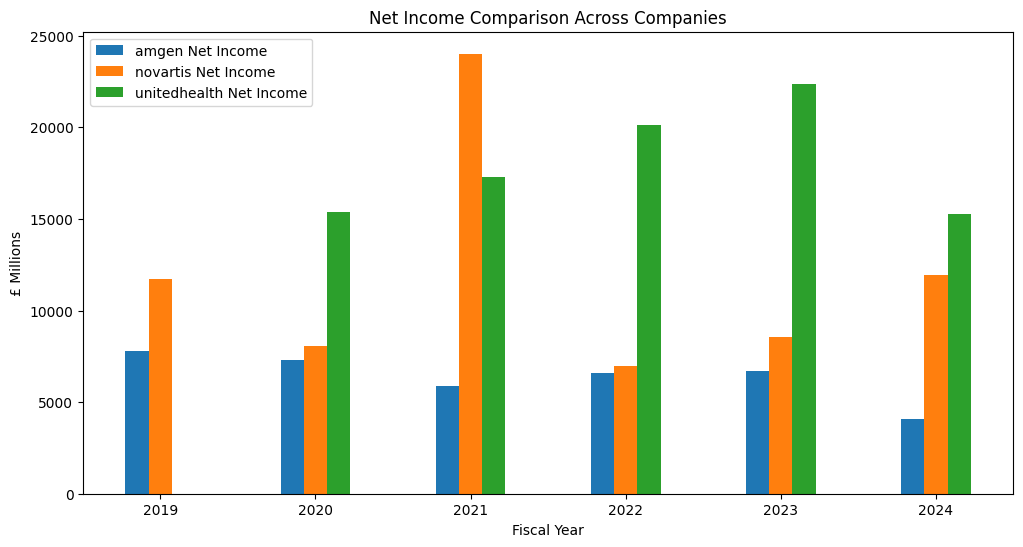

In [65]:
# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    net_incomes = [company_data[company_data["fiscal_year"] == y]["net_income_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, net_incomes, width=bar_width, label=f"{company} Net Income")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Net Income Comparison Across Companies")
plt.legend()
plt.show()

## Analyze total assets

### Subtask:
Visualize and compare the total assets of each company over time to understand their growth and scale.


**Reasoning**:
Filter the dataframe to include only annual reports and group by company and fiscal year to calculate the sum of total assets.



In [66]:
# Filter only annual reports
df_filtered = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    "total_assets_millions"
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years from the grouped dataframe and set up the plotting parameters.



In [67]:
# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

**Reasoning**:
Plot a grouped bar chart to visualize the total assets for each company across the fiscal years.



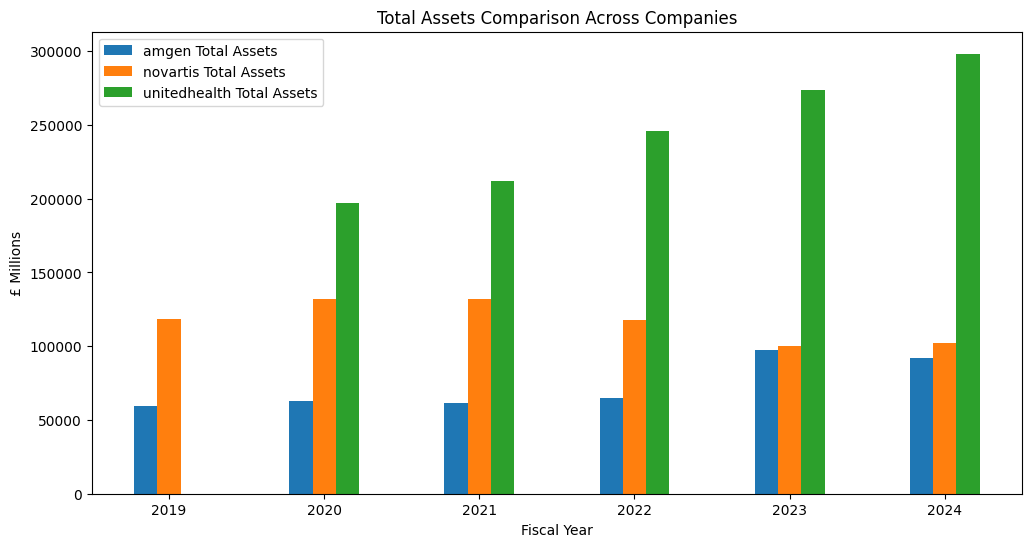

In [68]:
plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    total_assets = [company_data[company_data["fiscal_year"] == y]["total_assets_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, total_assets, width=bar_width, label=f"{company} Total Assets")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Total Assets Comparison Across Companies")
plt.legend()
plt.show()

## Analyze employee count

### Subtask:
Compare the employee counts across companies to understand their workforce size.


**Reasoning**:
Filter the DataFrame to include only annual reports and group by company and fiscal year to get the sum of employee counts.



In [69]:
# Filter only annual reports
df_filtered_employees = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped_employees = df_filtered_employees.groupby(["company_name", "fiscal_year"])[
    "employee_count"
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years, then create a bar chart to visualize the employee count for each company across the fiscal years, setting the labels and title as specified in the instructions.



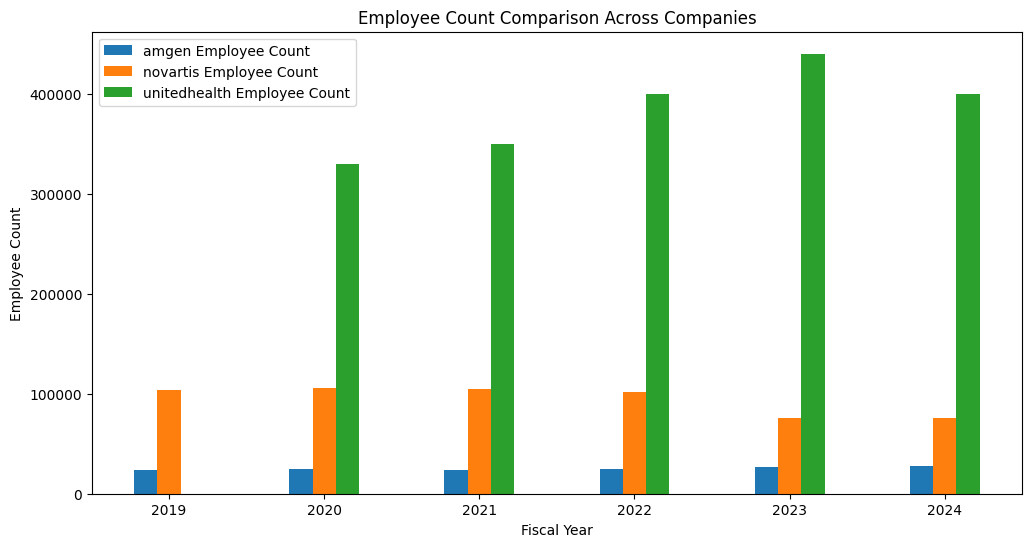

In [70]:
# Get unique values
companies_employees = df_grouped_employees["company_name"].unique().tolist()
years_employees = sorted(df_grouped_employees["fiscal_year"].unique())

# Set bar width
bar_width_employees = 0.15
x_employees = np.arange(len(years_employees))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies_employees):
    company_data = df_grouped_employees[df_grouped_employees["company_name"] == company]
    employee_counts = [company_data[company_data["fiscal_year"] == y]["employee_count"].sum() for y in years_employees]
    plt.bar(x_employees + i*bar_width_employees, employee_counts, width=bar_width_employees, label=f"{company} Employee Count")

plt.xticks(x_employees + bar_width_employees*(len(companies_employees)-1)/2, years_employees)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("Employee Count")
plt.title("Employee Count Comparison Across Companies")
plt.legend()
plt.show()

## Analyze esg metrics (ghg emissions)

### Subtask:
Visualize and compare the Scope 1, Scope 2, Scope 3, and Total GHG emissions for companies that have sustainability reports available.


**Reasoning**:
Filter the DataFrame to include only sustainability reports and then group by company and fiscal year to sum the GHG emissions columns.



In [71]:
# Filter only sustainability reports
df_filtered_esg = df_metrics[df_metrics["report_type"].str.lower() == "sustainability"]

# Group by company and year and sum GHG emission columns
df_grouped_esg = df_filtered_esg.groupby(["company_name", "fiscal_year"])[
    ["scope_1_ghg_emissions", "scope_2_ghg_emissions", "scope_3_ghg_emissions", "total_ghg_emissions"]
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years from the grouped ESG data and then iterate through each company to create a multi-line plot for their GHG emissions over the years.



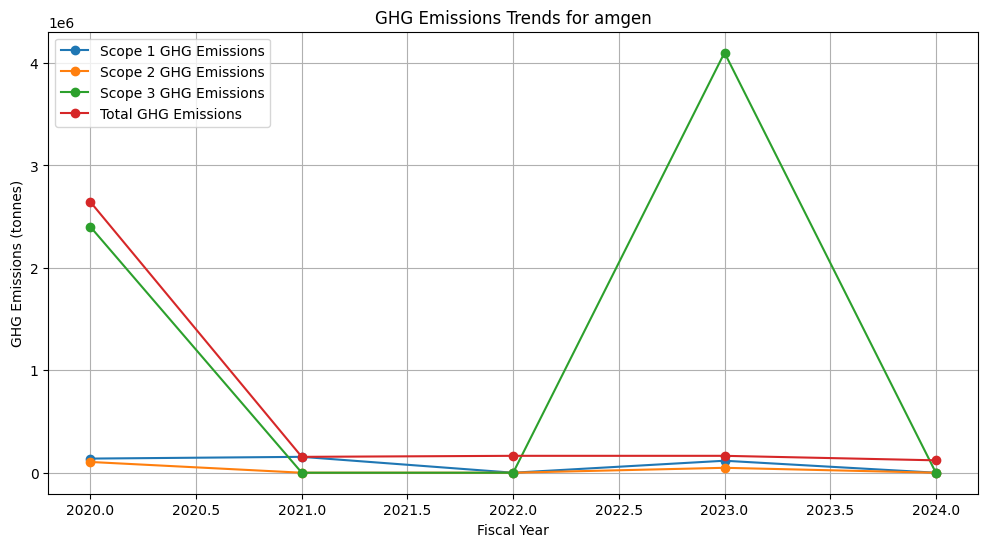

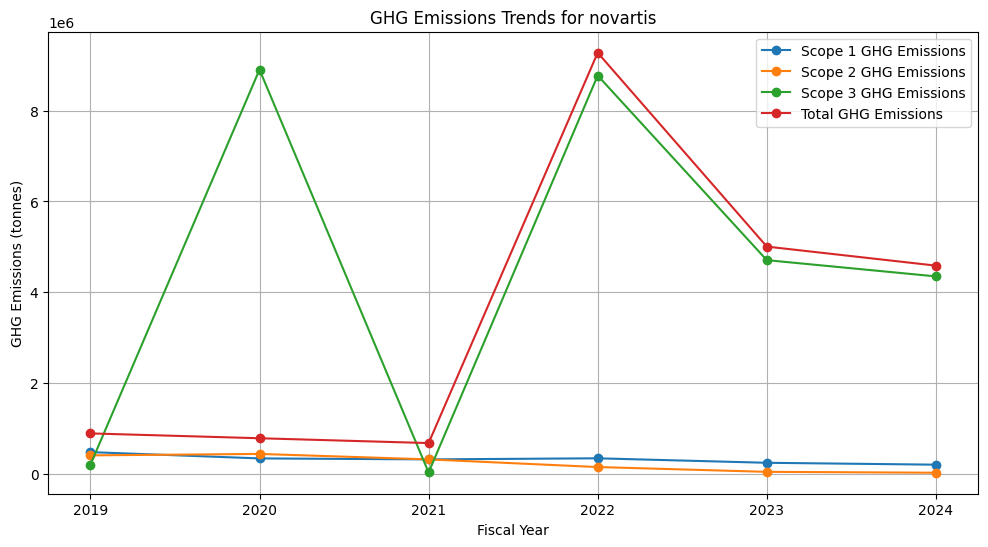

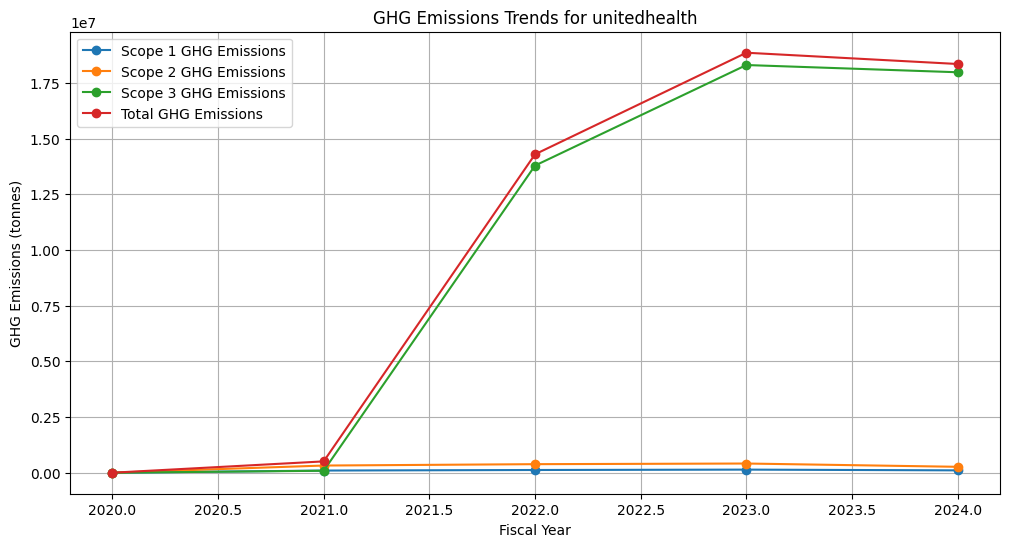

In [72]:
# Get unique values
companies_esg = df_grouped_esg["company_name"].unique().tolist()
years_esg = sorted(df_grouped_esg["fiscal_year"].unique())

# Plot GHG emissions for each company
for company in companies_esg:
    company_data_esg = df_grouped_esg[df_grouped_esg["company_name"] == company]

    plt.figure(figsize=(12, 6))
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_1_ghg_emissions"], marker="o", label="Scope 1 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_2_ghg_emissions"], marker="o", label="Scope 2 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_3_ghg_emissions"], marker="o", label="Scope 3 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["total_ghg_emissions"], marker="o", label="Total GHG Emissions")

    plt.xlabel("Fiscal Year")
    plt.ylabel("GHG Emissions (tonnes)")
    plt.title(f"GHG Emissions Trends for {company}")
    plt.legend()
    plt.grid(True)
    plt.show()